In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
print(os.listdir())

['.config', 'drive', 'sample_data']


In [4]:
import tensorflow as tf
import os,sys
import numpy as np
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(2)

import numpy as np
np.random.seed(10)

import os, keras, numpy,tensorflow
import matplotlib.pyplot as plt
from numpy import *
from numpy.random import *
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import *
from tensorflow.keras import initializers

from keras.layers import *
from keras.layers import Dense
from keras.layers.core import Activation
from keras.initializers import RandomNormal
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers import add
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization

In [6]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print("Number of Accelerator: ",strategy.num_replicas_in_sync)
with strategy.scope():
  # model = create_model()
  print("Ready To Go !")

Number of Accelerator:  1
Ready To Go !


In [7]:
def Discriminator(input_shape_in = (256, 256, 1), target_shape_in = (256, 256, 3)):

    # input
    input_shape = Input(shape = input_shape_in)
    input_target = Input(shape = target_shape_in)

    concate_one = Concatenate()([input_shape, input_target])

    # C64
    model = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(concate_one)
    model = LeakyReLU(alpha=0.2)(model)

    # C128
    model = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(model)
    model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)

    # C256
    model = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(model)
    model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)

    # C512
    model = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(model)
    model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)

    # second last output layer
    model = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(model)
    model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)

    # patch output
    model = Conv2D(1, (4,4), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(model)
    model = Activation('tanh')(model)

    # define model
    discriminator_model = Model(inputs = [input_shape, input_target], outputs = model)

    # compile model
    opt = Adam(learning_rate=0.0004, beta_1=0.5)
    discriminator_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])

    return discriminator_model

In [8]:
a = Discriminator()
print(a.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 4)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [9]:
# # plot the discriminator model
# tf.keras.utils.plot_model(a,show_shapes=True,
#                           show_dtype=True,
#                           show_layer_names=True,
#                           show_layer_activations=True)

In [10]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)

    return g


In [11]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)

    return g

In [12]:
# define the standalone generator model
def Generator(image_shape=(256,256,1)):

    # image input
    in_image = Input(shape=image_shape)

    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 256)
    e5 = define_encoder_block(e4, 256)
    e6 = define_encoder_block(e5, 512)

    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(e6)
    b = Activation('relu')(b)

    # decoder model
    d2 = decoder_block(b, e6, 512)
    d3 = decoder_block(d2, e5, 256)
    d4 = decoder_block(d3, e4, 256)
    d5 = decoder_block(d4, e3, 256)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(d7)
    out_image = Activation('tanh')(g)

    # model
    model = Model(in_image, out_image)

    return model

In [13]:
b = Generator()
print(b.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 64  1088        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_6[0][0]']               
                                )                                                           

In [ ]:
# # plot the discriminator model
# tf.keras.utils.plot_model(b,show_shapes=True,
#                           show_dtype=True,
#                           show_layer_names=True,
#                           show_layer_activations=True)

In [15]:
# define the combined generator and discriminator model, for updating the generator
def GAN(g_model, d_model, image_shape = (256, 256, 1)):

    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False


    in_src = Input(shape=image_shape)

    gen_out = g_model(in_src)

    dis_out = d_model([in_src, gen_out])

    model = Model(in_src, [dis_out, gen_out])

    # compile model
    opt = Adam(learning_rate=0.0004, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=opt, loss_weights=[1,100])

    return model

In [16]:
c = GAN(b, a)
print(c.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 256, 256, 3)  22959747    ['input_4[0][0]']                
                                                                                                  
 model (Functional)             (None, 8, 8, 1)      6966209     ['input_4[0][0]',                
                                                                  'model_1[0][0]']                
                                                                                            

In [17]:
# # plot the discriminator model
# tf.keras.utils.plot_model(c,show_shapes=True,
#                           show_dtype=True,
#                           show_layer_names=True,
#                           show_layer_activations=True)

In [18]:
def show_prediction(bw_images, rgb_images, predicted_rgb, n):

  plt.rcParams["figure.figsize"] = (13,13)
  for i in range(n):

    plt.subplot(331)
    plt.imshow(bw_images[i], cmap='gray')
    plt.title("B&W Image")
    plt.axis('off')

    plt.subplot(332)
    plt.imshow(rgb_images[i])
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(333)
    plt.imshow(predicted_rgb[i])
    plt.title("Prediction")
    plt.axis('off')

    plt.show()

In [19]:
def load_data():
    data = np.load("/content/drive/MyDrive/GodColoring/Dataset/rgb_bw_256_256_god.npz")
    rgb, bw = data['a'], data['b']
    rgb, bw = np.array(rgb), np.array(bw)
    rgb, bw = rgb.astype('float32'), bw.astype('float32')
    rgb = rgb.reshape((rgb.shape[0], rgb.shape[1], rgb.shape[2], 3))
    bw = bw.reshape((bw.shape[0], bw.shape[1], bw.shape[2], 1))
    # scale from [0,255] to [-1,1]
    rgb = (rgb - 127.5) / 127.5
    bw = (bw - 127.5) / 127.5
    return rgb, bw

In [20]:
def generate_real_samples(rgb_images, bw_images, n_samples, patch_size):
    ix = randint(0, rgb_images.shape[0], n_samples)
    rgb_images = rgb_images[ix]
    bw_images = bw_images[ix]
    y = ones((n_samples, patch_size, patch_size, 1))
    return [bw_images, rgb_images], y

In [21]:
def generate_fake_samples(generator, bw_images, n_samples, patch_size):
    pred_rgb_images = generator.predict(bw_images,verbose=0)
    y = zeros((n_samples, patch_size, patch_size, 1))
    return pred_rgb_images, y

In [22]:
def summarize_the_model(generator, rgb_images, bw_images, n_samples = 1, save = False):
    kk = 1056
    bw_images = bw_images[kk]
    bw_images = bw_images.reshape((1, bw_images.shape[0], bw_images.shape[1], 1))
    rgb_images = rgb_images[kk]
    rgb_images = rgb_images.reshape((1, rgb_images.shape[0], rgb_images.shape[1], 3))
    predicted_rgb  = generator.predict(bw_images,verbose=0)
    # scale from [-1,1] to [0,1]
    # X = (X + 1) / 2.0
    bw_images = (bw_images + 1.0) / 2.0
    rgb_images = (rgb_images + 1.0) / 2.0
    predicted_rgb = (predicted_rgb + 1.0) / 2.0
    show_prediction(bw_images, rgb_images, predicted_rgb, n = n_samples, save = save)

In [23]:
def train(g_model, d_model, gan_model, dataset, n_epochs=3, n_batch=128):

    rgb_images, bw_images = dataset

    print("No. of Data: ",rgb_images.shape)
    print("No. of Iteration: ",n_epochs)
    bat_per_epo = int(rgb_images.shape[0] / n_batch)
    print("No. of Batch in One Iteration: ", bat_per_epo)
    print("Full Batch of Data in One Batch of One Itertion: ",n_batch)

    print("*"*60,'\n\n')

    patch_size = d_model.output_shape[1]

    for i in range(n_epochs):

        for j in range(bat_per_epo):

            [bw_real, rgb_real], y_real = generate_real_samples(rgb_images, bw_images, n_batch, patch_size)
            d_model.train_on_batch([bw_real, rgb_real], y_real)
        
            pred_rgb, y_fake = generate_fake_samples(g_model, bw_real, n_batch, patch_size) # Trick 1 is Here
            d_model.train_on_batch([bw_real, pred_rgb], y_fake)
            
            gan_model.train_on_batch(bw_real, [y_real, rgb_real]) # Trick 2 is Here

            del bw_real, rgb_real, y_real, pred_rgb, y_fake

        if(i%30==0):
            summarize_the_model(g_model, rgb_images, bw_images, n_samples = 1, save=False)
        g_model.save("/content/drive/MyDrive/GodColoring/Model1/PixToPixGAN_GodColoring_Generator_Model.h5")


READY TO GO !!!

No. of Data:  (2077, 256, 256, 3)
No. of Iteration:  1500
No. of Batch in One Iteration:  32
Full Batch of Data in One Batch of One Itertion:  64
************************************************************ 




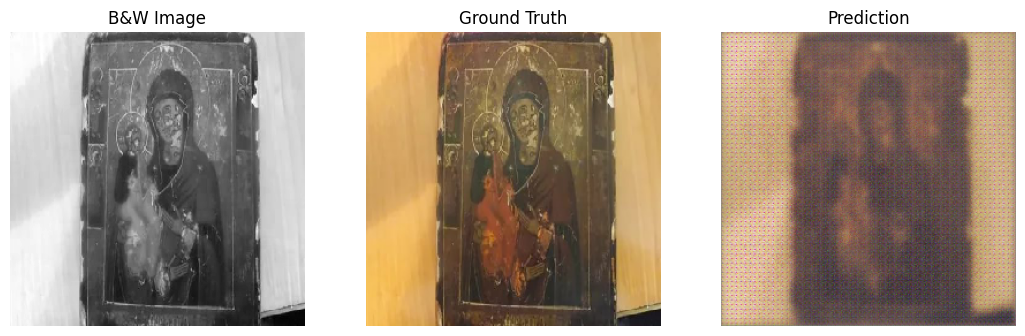

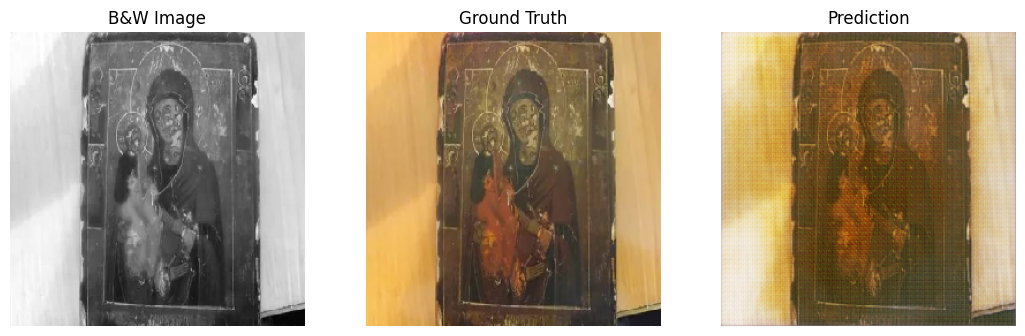

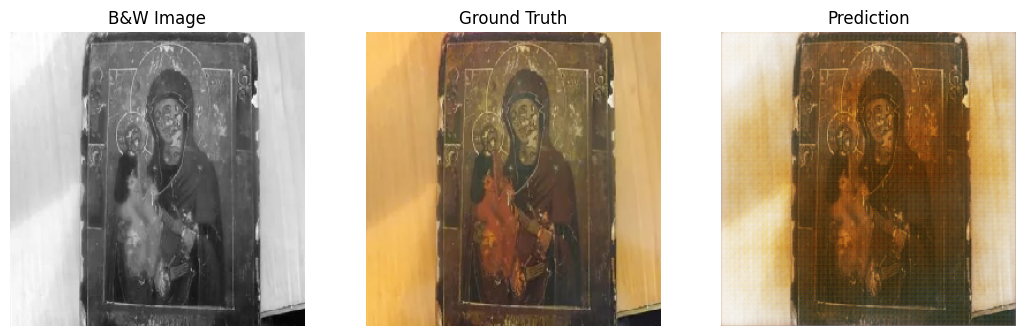

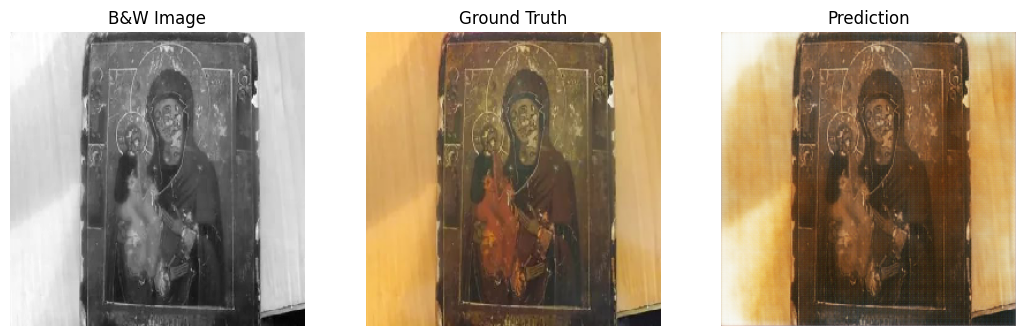

In [ ]:
with strategy.scope():

    n_epochs = 1500
    n_batch = 64

    d_model = Discriminator()
    g_model = Generator()
    gan_model = GAN(g_model, d_model)

    dataset = load_data()
    print("\nREADY TO GO !!!\n")

    train(g_model, d_model, gan_model, dataset, n_epochs, n_batch)

                                                -: END :-